In [ ]:
# Copyright (c) 2025, ETH Zurich

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as scis
import scipy.io
from scipy import interpolate
import h5py
import multiprocessing as mp
from multiprocessing import Pool
import sys
sys.path.append("path/to/ravesim/nist_lookup/nist_lookup/")
from nist_lookup.xraydb_plugin import xray_delta_beta
import scipy.signal as signal
from importlib import reload  

In [3]:
# constants
h = 6.62607004 * 10**(-34) # planck constant in mˆ2 kg / s
c_0 = 299792458 # speed of light in m / s
eV_to_joule = 1.602176634*10**(-19)
N_A = 6.02214086 * 10**23 #[1/mol]

# interferometer design

4.239379951514886e-06
3.5760978053346372e-06 [5.53261195e-05]


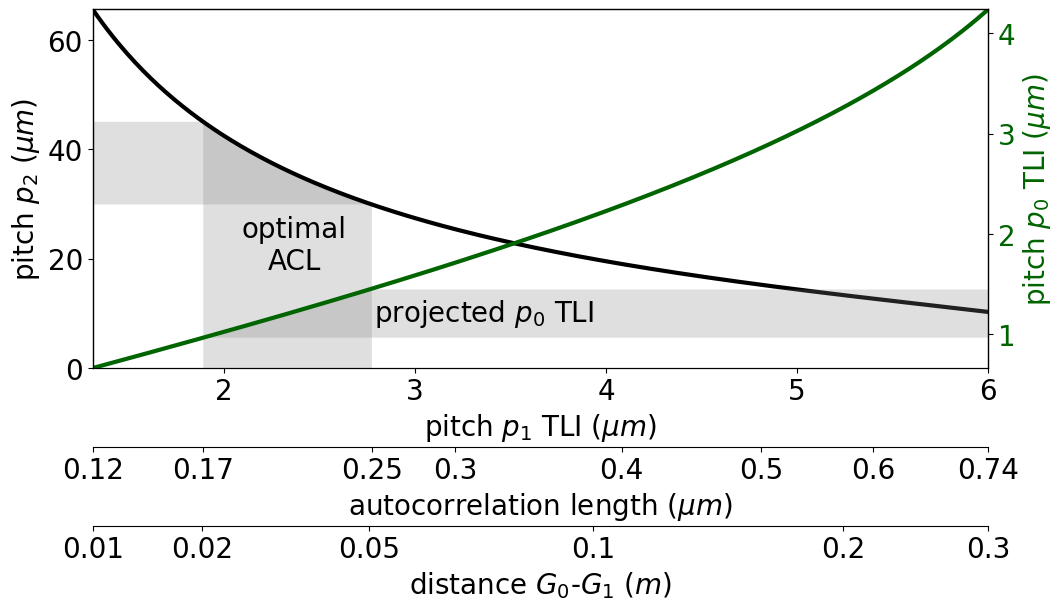

In [6]:
s=1
n=1
neta=2
lambda_ = h * c_0 / (57000*eV_to_joule)
p1=np.linspace(0.5,3*neta, 400)*1e-6
Dn = n*(p1/neta)**2/2/lambda_
l=s/2-(s**2/4-s*Dn)**0.5
d=s-l
M=s/l

p2 = M*(p1/neta)
p0 = l/d*p2

def acl_of_p1(p1_):
    Dn_ = n*(p1_/neta)**2/2/lambda_
    l_ = (s/2-(s**2/4-s*Dn)**0.5)
    p2_ = s/l_*p1_/neta
    return 0.35*lambda_/p2_

def p1_of_acl(acl_):
    p2_ = 0.35*lambda_/acl_
    l_ = s/(1+n/s*p2_**2/2/lambda_)
    return p2_/s*l_*neta

def l_of_p1(p1_):
    Dn_ = n*(np.asarray(p1_)/neta)**2/2/lambda_
    return s/2-(s**2/4-s*Dn_)**0.5

def p1_of_l(l_):
    return (2*lambda_*neta**2/s/n*(s**2/4-(l_-s/2)**2))**0.5

low=0.01
high=s-0.7
p2_col = "black"
p0_col = "darkgreen"

font_size=20

p2_max = 45e-6
p2_min=30e-6

print(p0[p2<60*1e-6].max())
fig_, axs = plt.subplots(figsize=(11,7))
ax2 = axs.twinx()


xx, yy = np.meshgrid(l, np.linspace(p2.max(),p2.min(),200))
p0_ar = (xx)/(s-xx)*yy


p0_param_min = p0[(l>low) * (l<high)].min()
p0_param_max = p0[(l>low) * (l<high)].max()
p0_param_range = (p0_param_max)-(p0_param_min)

p1_param_min = p1[(l>low) * (l<high)].min()
p1_param_max = p1[(l>low) * (l<high)].max()
p1_param_range = (p1_param_max)-(p1_param_min)

p2_param_min = M[np.where(p1==p1_param_max)]*(p1_param_max/neta)
p2_param_max = p2[(l>low) * (l<high)].max()
p2_param_range = p2_param_max-p2_param_min
print(p0_param_range, p2_param_range)

ax2y = axs.twiny()
ax2y.spines["bottom"].set_position(("axes", -0.22))
ax2y.xaxis.set_ticks_position("bottom")
ax2y.xaxis.set_label_position("bottom")
ax2y.set_xlabel("autocorrelation length ($\mu m$)", fontsize=font_size, color=p2_col)
ax2y.set_xlim(p1_param_min*1e6, p1_param_max*1e6)
ax2y.tick_params(axis='x', labelcolor=p2_col)

axs.set_xlim(p1_param_min*1e6, p1_param_max*1e6)
axs.set_ylim(0,p2_param_max*1e6)

ax2.set_ylim(p0_param_min*1e6, p0_param_max*1e6)
ax2y.set_xticks([p1[(l>low) * (l<high)].min()*1e6, p1[p2>p2_max].max()*1e6, p1[p2<p2_min].min()*1e6, p1_of_acl(0.3e-6)*1e6 , p1_of_acl(0.4e-6)*1e6, p1_of_acl(0.5e-6)*1e6, p1_of_acl(0.6e-6)*1e6, p1[(l>low) * (l<high)].max()*1e6])
ax2y.set_xticklabels([f'{round(0.35*lambda_/p2[(l>low) * (l<high)].max()*1e6, 2)}',f'{round(0.35*lambda_/p2_max*1e6,2)}', f'{round(0.35*lambda_/p2_min*1e6,2)}', "0.3", "0.4", "0.5", "0.6",f'{round(0.35*lambda_/p2[(l>low) * (l<high)].min()*1e6, 2)}'])
axs.set_ylabel(r'pitch $p_2$ ($\mu m$)', color=p2_col, fontsize=font_size)  # we already handled the x-label with ax1
axs.tick_params(axis='y', labelcolor=p2_col)
ax2.set_ylabel(r'pitch $p_0$ TLI ($\mu m$)', color=p0_col, fontsize=font_size)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=p0_col)
axs.set_xlabel(r"pitch $p_1$ TLI ($\mu m$)", fontsize=font_size, color=p2_col)
axs.tick_params(axis='x', labelcolor=p2_col)

ax3 = axs.twiny()
ax3.xaxis.set_ticks_position("bottom")
ax3.xaxis.set_label_position("bottom")



# Offset the twin axis below the host
ax3.spines["bottom"].set_position(("axes", -0.44))

new_tick_locations = np.asarray([p1_of_l(low), p1[p2>p2_max].max(), p1[p2<p2_min].min(), p1_of_l(0.1), p1_of_l(0.2), p1_of_l(high)])
ax3.set_xlim(p1_of_l(low)*1e6, p1_of_l(high)*1e6)
ax3.set_xticks(new_tick_locations*1e6)
ax3.set_xticklabels(np.round(l_of_p1(new_tick_locations),2))
ax3.set_xlabel(r"distance $G_0$-$G_1$ ($m$)", fontsize=font_size)


fill_alpha = 0.5

ax2.fill_betweenx(p0[(l>low) * (l<high)]*1e6, p1[(l>low) * (l<high)]*1e6, 6, where=(p0[(l>low) * (l<high)]*1e6>=p0[p2>p2_max].max()*1e6)*(p0[(l>low) * (l<high)]*1e6<=p0[p2>p2_min].max()*1e6), interpolate=False, color='gray', alpha=0.25, edgecolor=None)

p0_max_intersection = p0[p2>p2_min].max()
p0_min_intersection = p0[p2>p2_max].max()
p0_intersection_max_offset = (p0_max_intersection-p0_param_min)/p0_param_range
p0_intersection_min_offset = (p0_min_intersection-p0_param_min)/p0_param_range
p2_value_from_intersection_max = p0_intersection_max_offset*p2_param_range+p2_param_min
p2_value_from_intersection_min = p0_intersection_min_offset*p2_param_range+p2_param_min

axs.fill_betweenx(p2[(l>low) * (l<high)]*1e6, 0, p1[(l>low) * (l<high)]*1e6, where=(p1[(l>low) * (l<high)]<=p1[p2<p2_min].min()) * (p1[(l>low) * (l<high)]>=p1[p2>p2_max].max()), interpolate=False, color='gray', alpha=0.25, edgecolor=None)

axs.fill_between(p1[(l>low) * (l<high)]*1e6, p2[(l>low) * (l<high)]*1e6, 0, where=(p1[(l>low) * (l<high)]<=p1[p2<p2_min].min()) * (p1[(l>low) * (l<high)]>=p1[p2>p2_max].max()), interpolate=False, color='gray', alpha=0.25, edgecolor=None)
ax2.plot(p1[(l>low) * (l<high)]*1e6, p0[(l>low) * (l<high)]*1e6, color=p0_col, lw=3)
axs.plot(p1[(l>low) * (l<high)]*1e6, p2[(l>low) * (l<high)]*1e6, color=p2_col, lw=3)

axs.xaxis.set_tick_params(labelsize=font_size)
axs.yaxis.set_tick_params(labelsize=font_size)
ax2.xaxis.set_tick_params(labelsize=font_size)
ax2.yaxis.set_tick_params(labelsize=font_size)
ax2y.xaxis.set_tick_params(labelsize=font_size)
ax2y.yaxis.set_tick_params(labelsize=font_size)
ax3.xaxis.set_tick_params(labelsize=font_size)
ax3.yaxis.set_tick_params(labelsize=font_size)
plt.text(2.1, 18, "optimal\nACL", fontsize=font_size, ma='center')
plt.text(2.8, 8.5, r"projected $p_0$ TLI", fontsize=font_size, ma='center')

fig_.tight_layout()

4.239379951514886e-06
3.5760978053346372e-06 [5.53261195e-05]


Text(1.5, 15, 'higher order systems')

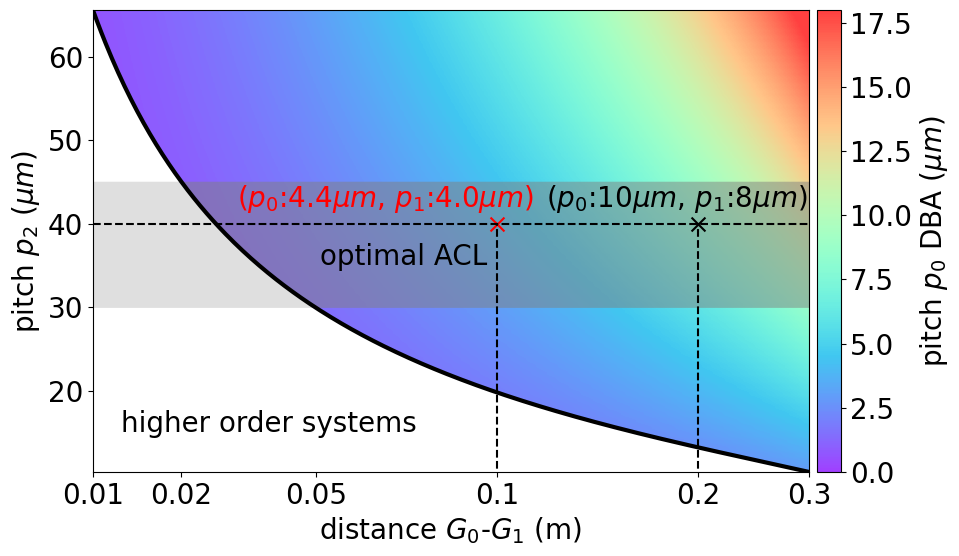

In [7]:
s=1
n=1
neta=2
lambda_ = h * c_0 / (57000*eV_to_joule)
p1=np.linspace(0.5,3*neta, 400)*1e-6
Dn = n*(p1/neta)**2/2/lambda_
l=s/2-(s**2/4-s*Dn)**0.5
d=s-l
M=s/l

p2 = M*(p1/neta)
p0 = l/d*p2

def acl_of_p1(p1_):
    Dn_ = n*(p1_/neta)**2/2/lambda_
    l_ = (s/2-(s**2/4-s*Dn)**0.5)
    p2_ = s/l_*p1_/neta
    return 0.35*lambda_/p2_

def p1_of_acl(acl_):
    p2_ = 0.35*lambda_/acl_
    l_ = s/(1+n/s*p2_**2/2/lambda_)
    return p2_/s*l_*neta

def l_of_p1(p1_):
    Dn_ = n*(np.asarray(p1_)/neta)**2/2/lambda_
    return s/2-(s**2/4-s*Dn_)**0.5

def p1_of_l(l_):
    return (2*lambda_*neta**2/s/n*(s**2/4-(l_-s/2)**2))**0.5

low=0.01
high=s-0.7
p2_col = "black"
p0_col = "darkgreen"

font_size=20

p2_max = 45e-6
p2_min=30e-6

print(p0[p2<60*1e-6].max())
fig_, axs = plt.subplots(figsize=(11,6))
# ax2 = axs.twinx()


xx, yy = np.meshgrid(l, np.linspace(p2.max(),p2.min(),200))
p0_ar = (xx)/(s-xx)*yy
p1_ar = yy*1/((s)/(xx))

im = axs.imshow(p1_ar*1e6,extent=[p1.min()*1e6,p1.max()*1e6,p2.min()*1e6,p2.max()*1e6], vmin=0, vmax=18, aspect="auto", alpha=0.75, cmap="rainbow")

cbar = plt.colorbar(im, pad=0.01)
cbar.set_label(r'pitch $p_0$ DBA ($\mu m$)',fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size) 
axs.fill_between(p1[(l>low) * (l<high)]*1e6, p2[(l>low) * (l<high)]*1e6, 0, where=p2[(l>low) * (l<high)]*1e6>=p2[(l>low) * (l<high)]*1e6, interpolate=True, color='white', alpha=1)


p0_param_min = p0[(l>low) * (l<high)].min()
p0_param_max = p0[(l>low) * (l<high)].max()
p0_param_range = (p0_param_max)-(p0_param_min)

p1_param_min = p1[(l>low) * (l<high)].min()
p1_param_max = p1[(l>low) * (l<high)].max()
p1_param_range = (p1_param_max)-(p1_param_min)

p2_param_min = M[np.where(p1==p1_param_max)]*(p1_param_max/neta)
p2_param_max = p2[(l>low) * (l<high)].max()
p2_param_range = p2_param_max-p2_param_min
print(p0_param_range, p2_param_range)

axs.set_xlim(p1_param_min*1e6, p1_param_max*1e6)
axs.set_ylim(p2_param_min*1e6,p2_param_max*1e6)

axs.set_ylabel(r'pitch $p_2$ ($\mu m$)', color=p2_col, fontsize=font_size)  # we already handled the x-label with ax1
axs.tick_params(axis='y', labelcolor=p2_col)
axs.tick_params(axis='x', labelcolor=p2_col)

new_tick_locations = np.asarray([p1_of_l(low), p1[p2>p2_max].max(), p1[p2<p2_min].min(), p1_of_l(0.1), p1_of_l(0.2), 6e-6])
axs.set_xticks(new_tick_locations*1e6)
axs.set_xticklabels([*np.round(l_of_p1(new_tick_locations[:-1]),2), 0.3])
axs.set_xlabel(r"distance $G_0$-$G_1$ (m)", fontsize=font_size)

fill_alpha = 0.5

p0_max_intersection = p0[p2>p2_min].max()
p0_min_intersection = p0[p2>p2_max].max()
p0_intersection_max_offset = (p0_max_intersection-p0_param_min)/p0_param_range
p0_intersection_min_offset = (p0_min_intersection-p0_param_min)/p0_param_range
p2_value_from_intersection_max = p0_intersection_max_offset*p2_param_range+p2_param_min
p2_value_from_intersection_min = p0_intersection_min_offset*p2_param_range+p2_param_min

axs.fill_betweenx(p2[(l>low) * (l<high)]*1e6, 0, p1[(l>low) * (l<high)]*1e6, where=(p1[(l>low) * (l<high)]<=p1[p2<p2_min].min()) * (p1[(l>low) * (l<high)]>=p1[p2>p2_max].max()), interpolate=False, color='gray', alpha=0.25, edgecolor=None)
axs.fill_betweenx(p2[(l>low) * (l<high)]*1e6, p1[(l>low) * (l<high)]*1e6, 10, where=(p1[(l>low) * (l<high)]<=p1[p2<p2_min].min()) * (p1[(l>low) * (l<high)]>=p1[p2>p2_max].max()), interpolate=False, color='gray', alpha=0.5, edgecolor=None)
axs.plot(p1[(l>low) * (l<high)]*1e6, p2[(l>low) * (l<high)]*1e6, color=p2_col, lw=3)


axs.xaxis.set_tick_params(labelsize=font_size)
axs.yaxis.set_tick_params(labelsize=font_size)

axs.axhline(40, color=p2_col, linestyle="--")
axs.vlines(p1_of_l(0.2)*1e6, 0, 40, color='black', linestyle='--')
plt.scatter([p1_of_l(0.2)*1e6],[40], s=100, marker="x", color='black')
plt.text(p1_of_l(0.2)*1e6-1,40+2, f"($p_0$:{10}$\mu m$, $p_1$:{8}$\mu m$)", fontsize=font_size, ma='center')
plt.scatter([p1_of_l(0.1)*1e6],[40], s=100, marker="x", color='red')
axs.vlines(p1_of_l(0.1)*1e6, 0, 40, color='black', linestyle='--')
plt.text(p1_of_l(0.1)*1e6-1-0.7,40+2, f"($p_0$:{round(40*0.1/0.9,1)}$\mu m$, $p_1$:{40/1*0.1}$\mu m$)", fontsize=font_size, ma='center', color="red")
plt.text(2.8, 35, "optimal ACL", fontsize=font_size, ma='center')
plt.text(1.5, 15, "higher order systems", fontsize=font_size, ma='center')